In [1]:
import random
from transformers import pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np
from huggingface_hub import notebook_login
import wandb
import os
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
plt.rcParams['figure.figsize'] = 12, 8

In [4]:
# print(torch.__version__)
# print(torch.backends.cudnn.version())
# print(torchvision.__version__)
# print(torchtext.__version__)

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False  # 启用Cudnn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# 模型相关参数
base_model_name = 'roberta-llama3.1405B-twitter-sentiment'
TEST_DATASET_SIZE = 0.2
NUM_LABELS = 3
DATA_PATH = f'../data/corpus.txt'

# BASE_MODEL_PATH = f'./citation_finetuned_models/{base_model_name}'
BASE_MODEL_PATH = f'../pretrain_models/{base_model_name}'

# 训练相关参数
BATCH_SIZE = 32
loss_type='focal_loss' # 自定义参数 focal_loss dsc_loss ce_loss asymmetric_loss
weight_decay = 0.05  # 0.01
lr = 2.0e-5  # 2e-5学习率，bs设置较大 5e-6
num_epochs = 3
warmup_ratio = 0.1
warmup_steps = 100
label_smoothing_factor = 0.1

In [7]:
def load_sentiment_datasets(test_size=0.4, seed=42, filepath='../data/corpus.txt', is_split=True):
    sentences, labels = [], []
    if filepath == '../data/citation_sentiment_corpus.csv':
        df = pd.read_csv(filepath)
        label_map = {'o': 0, 'p': 1, 'n': 2}
        df['Sentiment'] = df['Sentiment'].map(label_map)
        sentences = df['Citation_Text'].tolist()
        labels = df['Sentiment'].tolist()
    elif filepath == '../data/citation_sentiment_corpus_balanced.csv':
        df = pd.read_csv(filepath)
        df = df[(df['Source'] == 'new') & (df['Sentiment'].isin([1, 2])) | (df['Source'] == 'original') & (
                    df['Sentiment'] == 0)] # 只选取新数据集中的正负样本和原始数据集中的中性样本
        sentences = df['Citation_Text'].tolist()
        labels = df['Sentiment'].tolist()
    elif filepath == '../data/corpus.txt':
        with open(filepath, "r", encoding="utf8") as f:
            file = f.read().split("\n")
            file = [i.split("\t") for i in file]
            for i in file:
                if len(i) == 2:
                    sentence = i[1]
                    label = int(i[0])
                    # Map labels: 2 -> Positive, 1 -> Neutral, 0 -> Negative
                    if label == 2:
                        label = 1
                    elif label == 1:
                        label = 0
                    elif label == 0:
                        label = 2
                    sentences.append(sentence)
                    labels.append(label)
    elif filepath == '../data/CSA_raw_dataset/augmented_context_full/combined.csv':
        df = pd.read_csv(filepath)
        labelmap = {'Neutral': 0, 'Positive': 1, 'Negative': 2}
        df['Sentiment'] = df['Sentiment'].map(labelmap)
        sentences = df['Text'].tolist()
        labels = df['Sentiment'].tolist()
    elif filepath == '../data/citation_sentiment_corpus_expand.csv':
        df = pd.read_csv(filepath)
        label_map = {'Neutral': 0, 'Positive': 1, 'Negative': 2}
        df['Sentiment'] = df['Sentiment'].map(label_map)
        sentences = df['Text'].tolist()
        labels = df['Sentiment'].tolist()

    if is_split:
        train_texts, temp_texts, train_labels, temp_labels = train_test_split(sentences,
                                                                              labels, test_size=test_size,
                                                                              stratify=labels, random_state=seed)
        # df_aug = pd.read_csv('../data/train_data_aug3.csv')
        # train_texts = df_aug['Citation_Text'].tolist()
        # train_labels = df_aug['Sentiment'].tolist() # 替换增强后的整个数据集
        # train_texts, train_labels = shuffle(train_texts, train_labels, random_state=seed) # 打乱新的训练集

        val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5,
                                                                          stratify=temp_labels, random_state=seed)
        return train_texts, train_labels, val_texts, val_labels, test_texts, test_labels
    else:
        return sentences, labels


train_texts, train_labels, val_texts, val_labels, test_texts, test_labels = load_sentiment_datasets(test_size=TEST_DATASET_SIZE, seed=seed, filepath=DATA_PATH, is_split=True)

## 使用Trainer类微调citation的情感分析

In [8]:
id2label={0:"Neutral", 1:"Positive", 2:"Negative"}
label2id={"Neutral":0, "Positive":1, "Negative":2}

class CustomBERTModel(AutoModelForSequenceClassification):
    def __init__(self, config):
        super(CustomBERTModel, self).__init__(config)
        self.bert = AutoModel.from_pretrained(config._name_or_path)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, config.num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the CLS token representation
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

# 加载基座模型和分词器
model = CustomBERTModel.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS).to(device)
# model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
import datasets

class MyDataset(torch.utils.data.Dataset):
    """
    重构数据集类，使其能够返回字典格式的数据，有标签
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = MyDataset(tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), train_labels)
test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
val_dataset = MyDataset(tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), val_labels)

# 将数据转换为 HuggingFace 的 Dataset 格式
train_data = datasets.Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_data = datasets.Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_data = datasets.Dataset.from_dict({'text': test_texts, 'label': test_labels})
emotion_data = datasets.DatasetDict({'train': train_data, 'validation': val_data, 'test': test_data})
tokenized_data = emotion_data.map(lambda f: tokenizer(f['text'], padding=True, truncation=True, return_tensors='pt', max_length=512), batch_size=16, batched=True)  # WordPiece分词器
# tokenized_data = tokenized_data.remove_columns(['text'])
# train_dataset = tokenized_data['train']
# val_dataset = tokenized_data['validation']
# test_dataset = tokenized_data['test']

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

Map:   0%|          | 0/6329 [00:00<?, ? examples/s]

Map:   0%|          | 0/791 [00:00<?, ? examples/s]

Map:   0%|          | 0/792 [00:00<?, ? examples/s]

Train Dataset Size: 6329
Test Dataset Size: 792
Val Dataset Size: 791


In [10]:
from custom_loss import MultiFocalLoss, MultiDSCLoss, AsymmetricLoss

class CustomTrainer(Trainer):
    def __init__(self, loss_type='focal_loss', *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0)
        elif self.loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0)
        elif self.loss_type == 'asymmetric_loss':
            loss_fct = AsymmetricLoss(gamma_pos=0.5, gamma_neg=3.0)
        elif self.loss_type == 'ce_loss':
            loss_fct = torch.nn.CrossEntropyLoss()
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainerCallback

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

class LossRecorderCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.eval_losses, label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss over Time')
        plt.show()

loss_recorder = LossRecorderCallback()

  0%|          | 0/594 [00:00<?, ?it/s]

{'loss': 0.1982, 'grad_norm': 2.4103786945343018, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.25}


  0%|          | 0/25 [00:00<?, ?it/s]

d:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.09900335222482681, 'eval_Accuracy': 0.8761061946902655, 'eval_F1': 0.5484611371935316, 'eval_Precision': 0.5277052139747266, 'eval_Recall': 0.5724405034908017, 'eval_runtime': 1.2739, 'eval_samples_per_second': 620.917, 'eval_steps_per_second': 19.624, 'epoch': 0.25}
{'loss': 0.0944, 'grad_norm': 2.0457746982574463, 'learning_rate': 1.8501872659176032e-05, 'epoch': 0.51}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.073520228266716, 'eval_Accuracy': 0.9039190897597977, 'eval_F1': 0.7225747539336389, 'eval_Precision': 0.8144048394913187, 'eval_Recall': 0.6839145840265476, 'eval_runtime': 1.2664, 'eval_samples_per_second': 624.625, 'eval_steps_per_second': 19.742, 'epoch': 0.51}
{'loss': 0.0757, 'grad_norm': 1.8964226245880127, 'learning_rate': 1.662921348314607e-05, 'epoch': 0.76}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.060823190957307816, 'eval_Accuracy': 0.9051833122629582, 'eval_F1': 0.7731103020299267, 'eval_Precision': 0.7975813406265785, 'eval_Recall': 0.7638825188129577, 'eval_runtime': 1.2792, 'eval_samples_per_second': 618.368, 'eval_steps_per_second': 19.544, 'epoch': 0.76}
{'loss': 0.0542, 'grad_norm': 1.5194127559661865, 'learning_rate': 1.4794007490636706e-05, 'epoch': 1.01}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.06294064223766327, 'eval_Accuracy': 0.9064475347661188, 'eval_F1': 0.8006634706400578, 'eval_Precision': 0.7586524822695035, 'eval_Recall': 0.8615055562050534, 'eval_runtime': 1.2731, 'eval_samples_per_second': 621.298, 'eval_steps_per_second': 19.636, 'epoch': 1.01}
{'loss': 0.0421, 'grad_norm': 3.710723876953125, 'learning_rate': 1.2921348314606743e-05, 'epoch': 1.26}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.06291147321462631, 'eval_Accuracy': 0.9127686472819216, 'eval_F1': 0.8299080037751473, 'eval_Precision': 0.7815879707700956, 'eval_Recall': 0.8984552440963135, 'eval_runtime': 1.2776, 'eval_samples_per_second': 619.109, 'eval_steps_per_second': 19.567, 'epoch': 1.26}
{'loss': 0.0463, 'grad_norm': 4.154745101928711, 'learning_rate': 1.104868913857678e-05, 'epoch': 1.52}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.059606991708278656, 'eval_Accuracy': 0.9279393173198482, 'eval_F1': 0.8440041620829097, 'eval_Precision': 0.8359044576296973, 'eval_Recall': 0.8525339912247832, 'eval_runtime': 1.2667, 'eval_samples_per_second': 624.443, 'eval_steps_per_second': 19.736, 'epoch': 1.52}
{'loss': 0.0373, 'grad_norm': 8.367795944213867, 'learning_rate': 9.176029962546817e-06, 'epoch': 1.77}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.0581415556371212, 'eval_Accuracy': 0.922882427307206, 'eval_F1': 0.843232586122813, 'eval_Precision': 0.8385154233451447, 'eval_Recall': 0.8482660403508088, 'eval_runtime': 1.2655, 'eval_samples_per_second': 625.029, 'eval_steps_per_second': 19.754, 'epoch': 1.77}
{'loss': 0.0406, 'grad_norm': 1.4201843738555908, 'learning_rate': 7.303370786516854e-06, 'epoch': 2.02}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.06655308604240417, 'eval_Accuracy': 0.9140328697850821, 'eval_F1': 0.8135148801428382, 'eval_Precision': 0.7833198503387603, 'eval_Recall': 0.8708813087483375, 'eval_runtime': 1.2671, 'eval_samples_per_second': 624.241, 'eval_steps_per_second': 19.729, 'epoch': 2.02}
{'loss': 0.0191, 'grad_norm': 6.071462631225586, 'learning_rate': 5.430711610486891e-06, 'epoch': 2.27}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.0680314153432846, 'eval_Accuracy': 0.9292035398230089, 'eval_F1': 0.8406912078105012, 'eval_Precision': 0.8721662754170495, 'eval_Recall': 0.8144207027967382, 'eval_runtime': 1.2652, 'eval_samples_per_second': 625.188, 'eval_steps_per_second': 19.759, 'epoch': 2.27}
{'loss': 0.0193, 'grad_norm': 0.1899498552083969, 'learning_rate': 3.558052434456929e-06, 'epoch': 2.53}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.06546119600534439, 'eval_Accuracy': 0.9266750948166877, 'eval_F1': 0.8388575328865723, 'eval_Precision': 0.8371833325688085, 'eval_Recall': 0.8405684905567995, 'eval_runtime': 1.2666, 'eval_samples_per_second': 624.526, 'eval_steps_per_second': 19.738, 'epoch': 2.53}
{'loss': 0.0191, 'grad_norm': 0.6304187178611755, 'learning_rate': 1.6853932584269663e-06, 'epoch': 2.78}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.06998652964830399, 'eval_Accuracy': 0.9165613147914032, 'eval_F1': 0.8136703741563752, 'eval_Precision': 0.796826335814024, 'eval_Recall': 0.8369867592351112, 'eval_runtime': 1.2855, 'eval_samples_per_second': 615.321, 'eval_steps_per_second': 19.448, 'epoch': 2.78}
{'train_runtime': 173.0206, 'train_samples_per_second': 109.738, 'train_steps_per_second': 3.433, 'train_loss': 0.0560482777529694, 'epoch': 3.0}
Training took: 173.15 seconds


  0%|          | 0/25 [00:00<?, ?it/s]

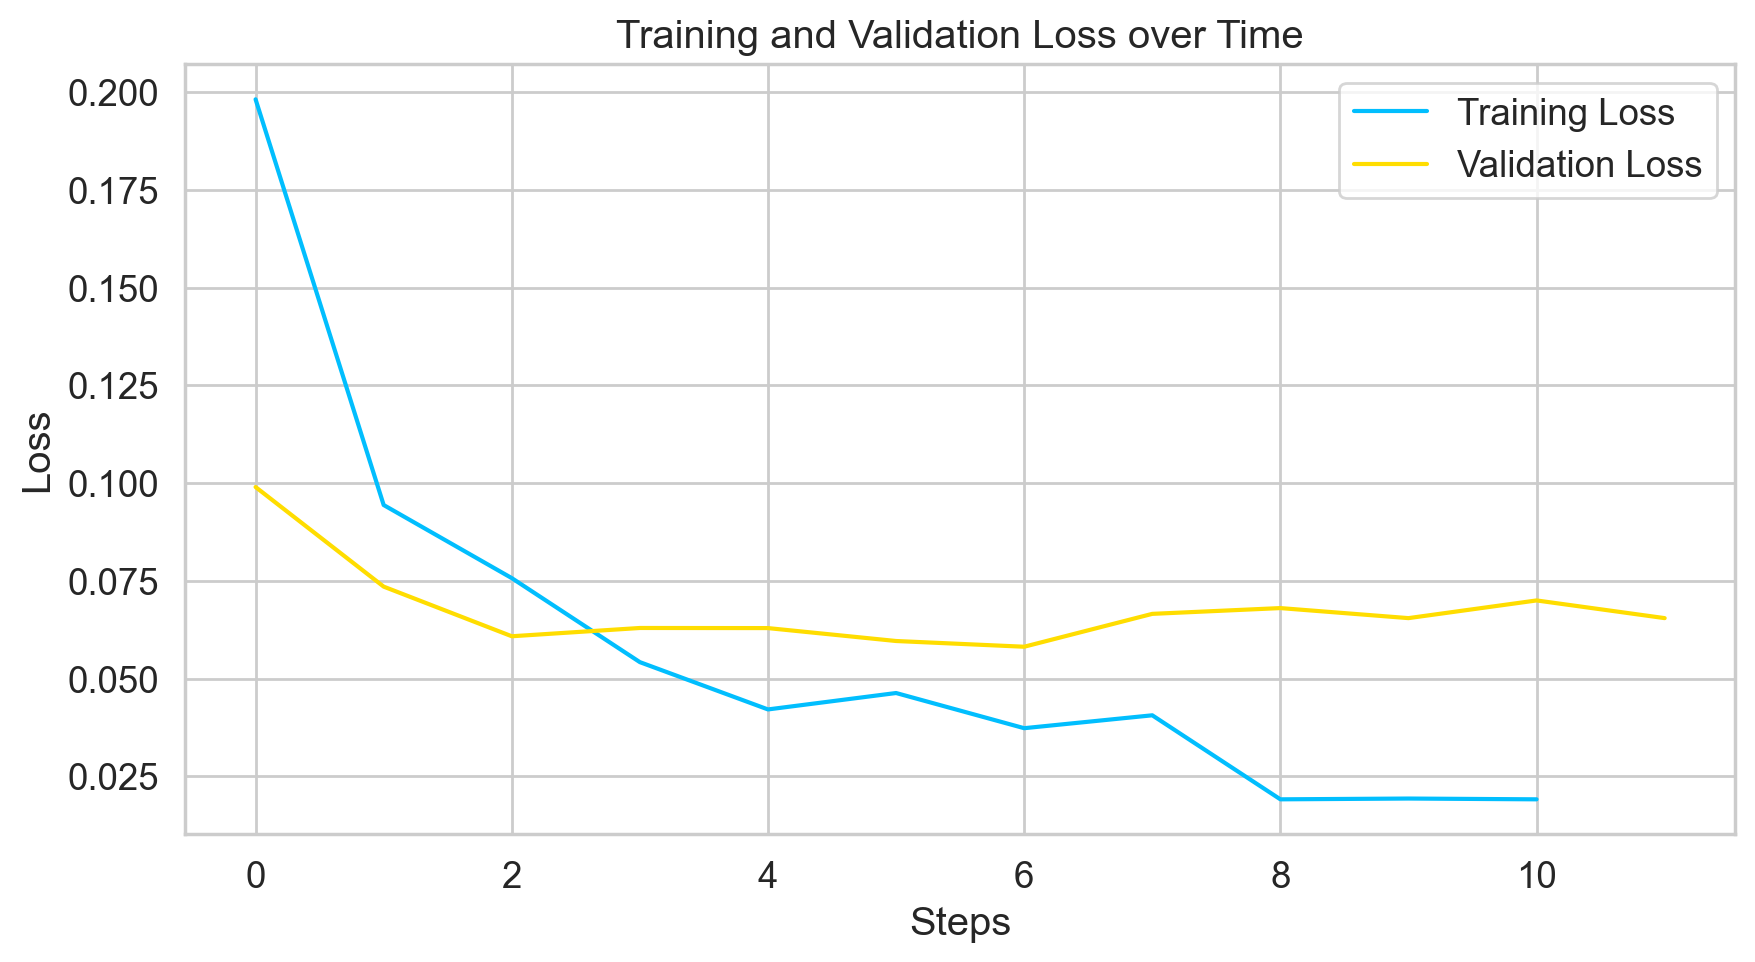

In [12]:
# 定义训练参数
training_args = TrainingArguments(
    output_dir=f'./results/{base_model_name}',          # 输出结果目录
    report_to='none',
    num_train_epochs=num_epochs,
    learning_rate=lr,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    # warmup_steps=warmup_steps,
    logging_strategy='steps',
    logging_dir=f'./logs/{base_model_name}',            # 日志目录
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    disable_tqdm=False,
    save_strategy="steps",
    fp16= torch.cuda.is_available(), # faster and use less memory
    metric_for_best_model='F1',
    load_best_model_at_end=True,
    greater_is_better=True,
    # push_to_hub=True,
    # label_smoothing_factor=label_smoothing_factor
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    loss_type=loss_type,  # 自定义参数 focal_loss dsc_loss
    callbacks=[loss_recorder]
)

start = time.time()
trainer.train()
train_time = time.time() - start
print(f"Training took: {train_time:.2f} seconds")
eval_result = trainer.evaluate()

loss_recorder.plot_losses()

# k-fold cross validation

In [13]:
# from sklearn.model_selection import KFold
# 
# # k折交叉验证
# k = 10
# kf = KFold(n_splits=k, shuffle=True, random_state=seed)
# 
# train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.1, stratify=labels, random_state=seed)
# results = []
# fold_counter = 1
# for train_index, val_index in kf.split(train_texts):
#     print(f"Training fold {fold_counter}/{k}")
#     fold_train_texts = [train_texts[i] for i in train_index]
#     fold_val_texts = [train_texts[i] for i in val_index]
#     fold_train_labels = [train_labels[i] for i in train_index]
#     fold_val_labels = [train_labels[i] for i in val_index]
# 
#     train_dataset = MyDataset(tokenizer(fold_train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), fold_train_labels)
#     val_dataset = MyDataset(tokenizer(fold_val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), fold_val_labels)
# 
#     # 独立的k次训练
#     model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)
# 
#     # 定义训练参数
#     training_args = TrainingArguments(
#         output_dir=f'./results/{base_model_name}',          # 输出结果目录
#         report_to='none',
#         num_train_epochs=num_epochs,
#         learning_rate=lr,
#         per_device_train_batch_size=BATCH_SIZE,
#         per_device_eval_batch_size=BATCH_SIZE,
#         weight_decay=weight_decay,
#         warmup_ratio=warmup_ratio,
#         # warmup_steps=warmup_steps,
#         logging_strategy='steps',
#         logging_dir=f'./logs/{base_model_name}',            # 日志目录
#         logging_steps=50,
#         eval_strategy="steps",
#         eval_steps=50,
#         disable_tqdm=False,
#         save_strategy="steps",
#         fp16= torch.cuda.is_available(), # faster and use less memory
#         metric_for_best_model='F1',
#         load_best_model_at_end=True,
#         greater_is_better=True,
#         # push_to_hub=True,
#         # label_smoothing_factor=label_smoothing_factor
#     )
# 
#     trainer = CustomTrainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=val_dataset,
#         tokenizer=tokenizer,
#         compute_metrics=compute_metrics,
#         loss_type=loss_type,  # 自定义参数 focal_loss dsc_loss
#         callbacks=[loss_recorder]
#     )
# 
#     start = time.time()
#     trainer.train()
#     train_time = time.time() - start
#     print(f"Training took: {train_time:.2f} seconds")
#     eval_result = trainer.evaluate()
#     results.append(eval_result)
#     
#     # 对测试集进行评估
#     test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
#     test_results = trainer.evaluate(test_dataset)
#     print(f"Test results for fold {fold_counter}: {test_results}")
# 
#     loss_recorder.plot_losses()
#     fold_counter += 1
# 
# # 计算平均结果
# avg_results = {key: np.mean([result[key] for result in results]) for key in results[0]}
# print("Average results:", avg_results)

## 评估模型:ROC曲线

accuracy、precision(预测为1/真实为1)、recall(真实为1/预测为1)和F1-score

F1-score = 2 * (precision * recall) / (precision + recall)

Micro-F1: 将所有类别的TP、FP、FN分别累加，然后计算F1-score

Macro-F1: 分别计算每个类别的F1-score，然后求平均

In [14]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import json

test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
test_results = trainer.evaluate(test_dataset)

# results_json = {
#     "model_name": base_model_name,
#     "avg_results": avg_results,
#     "test_results": test_results
# }
# 
# results_path = f'./output/bert_output.json'
# 
# if not os.path.exists(results_path):
#     with open(results_path, 'w') as json_file:
#         json.dump({}, json_file)
# 
# with open(results_path, 'w') as json_file:
#     json.dump(results_json, json_file, indent=4)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

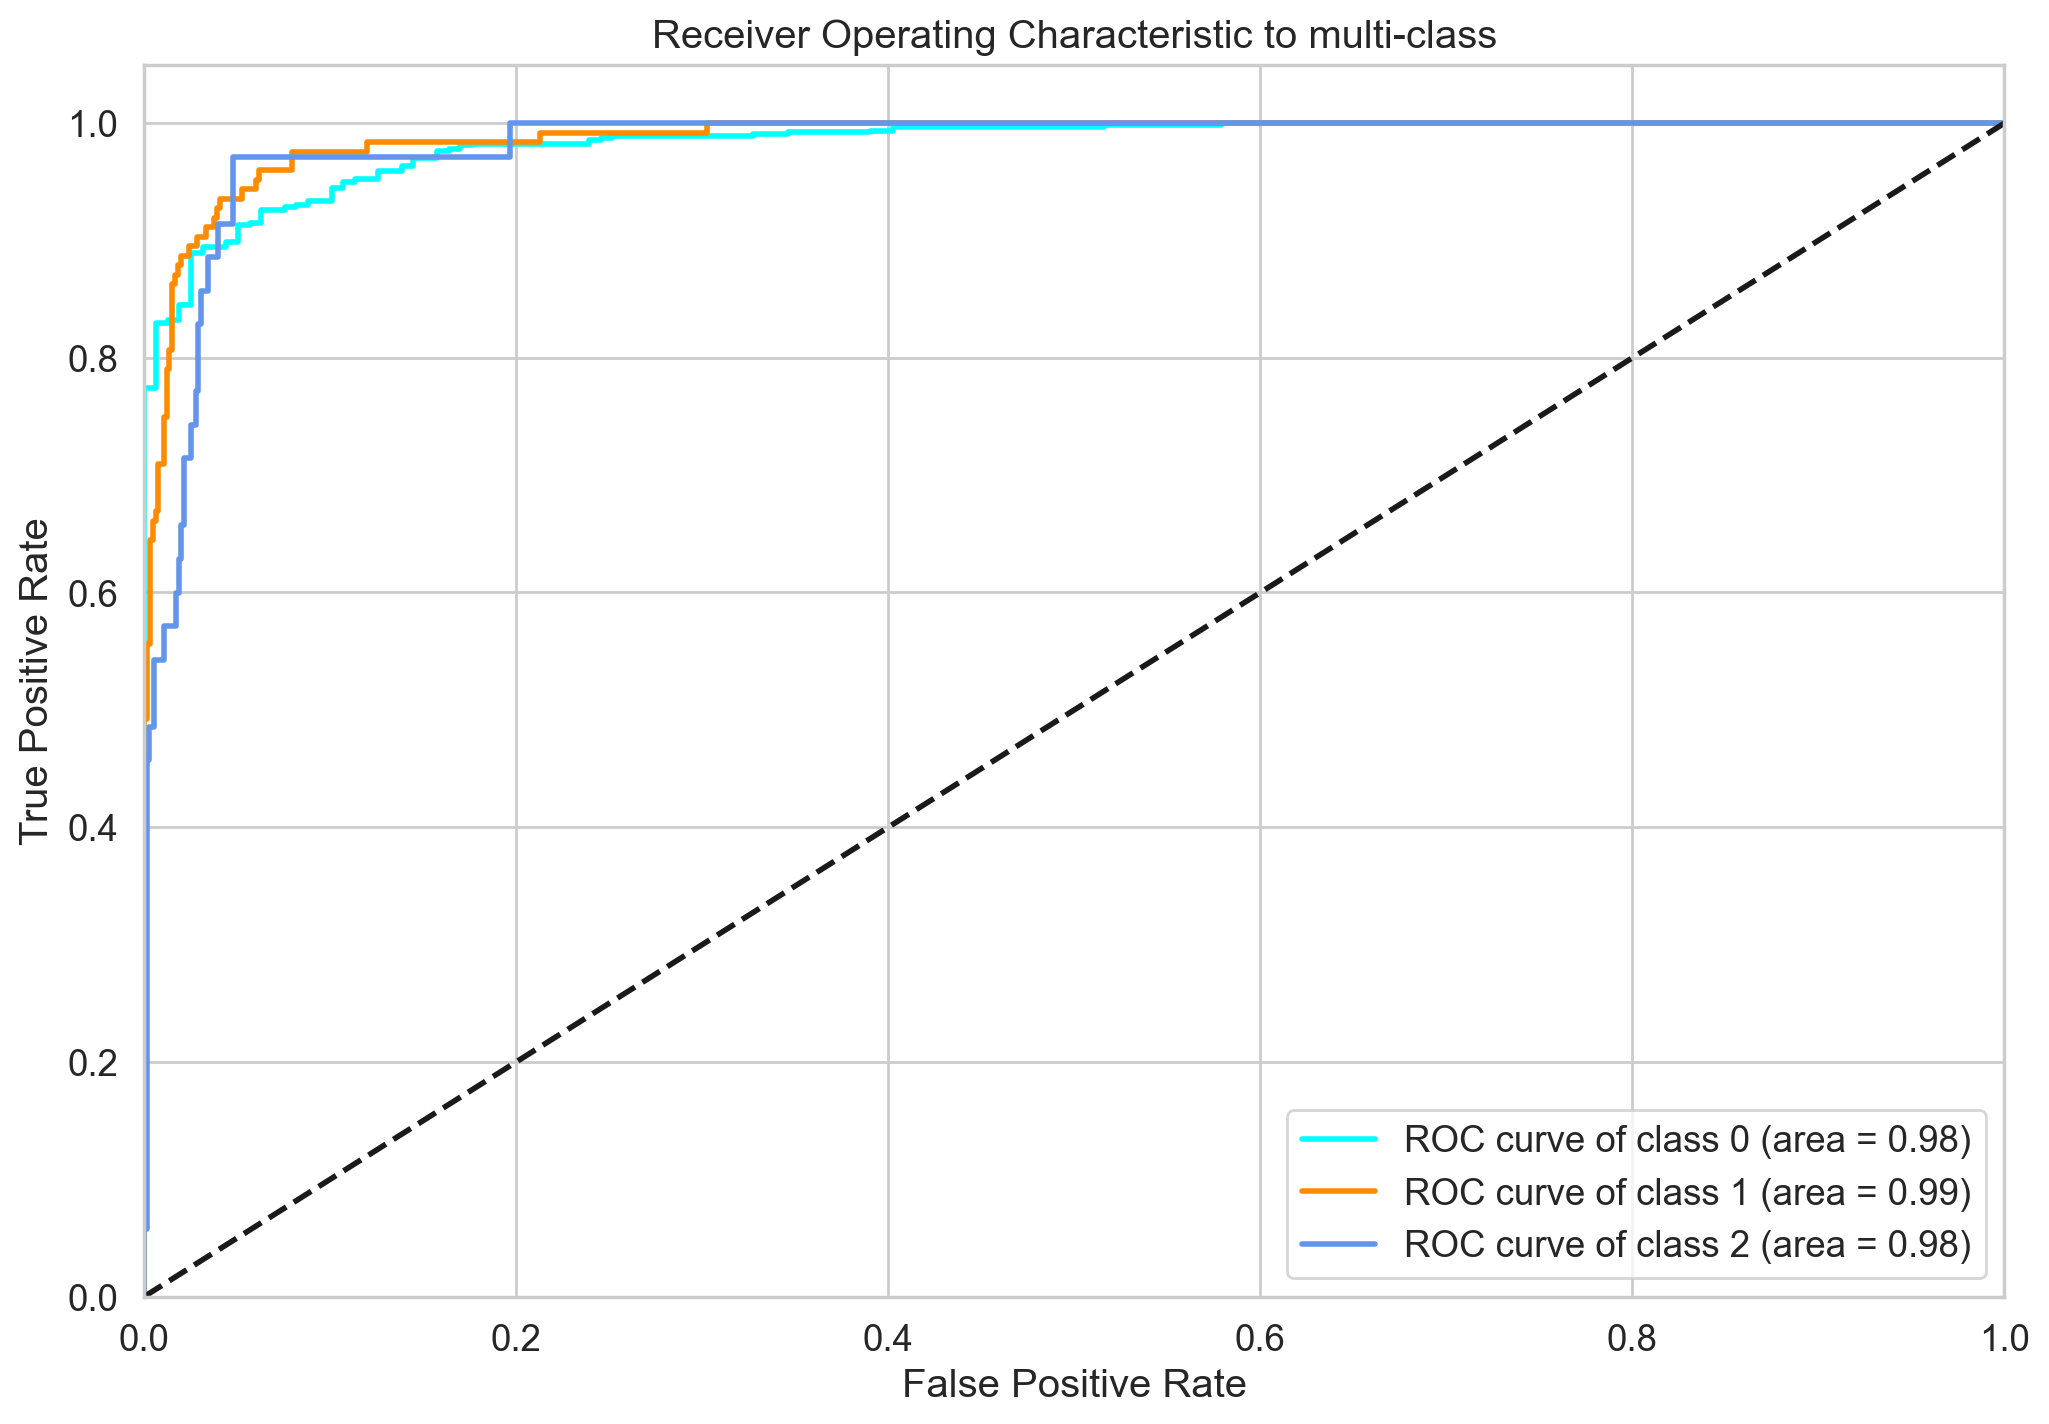

In [15]:
def plot_roc_curve(labels, probs):
    # 计算ROC曲线
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # 将标签转换为One-hot编码
    test_labels_one_hot = np.eye(3)[labels]
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 绘制ROC曲线
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()
plot_roc_curve(test_labels, probs)

## PR曲线

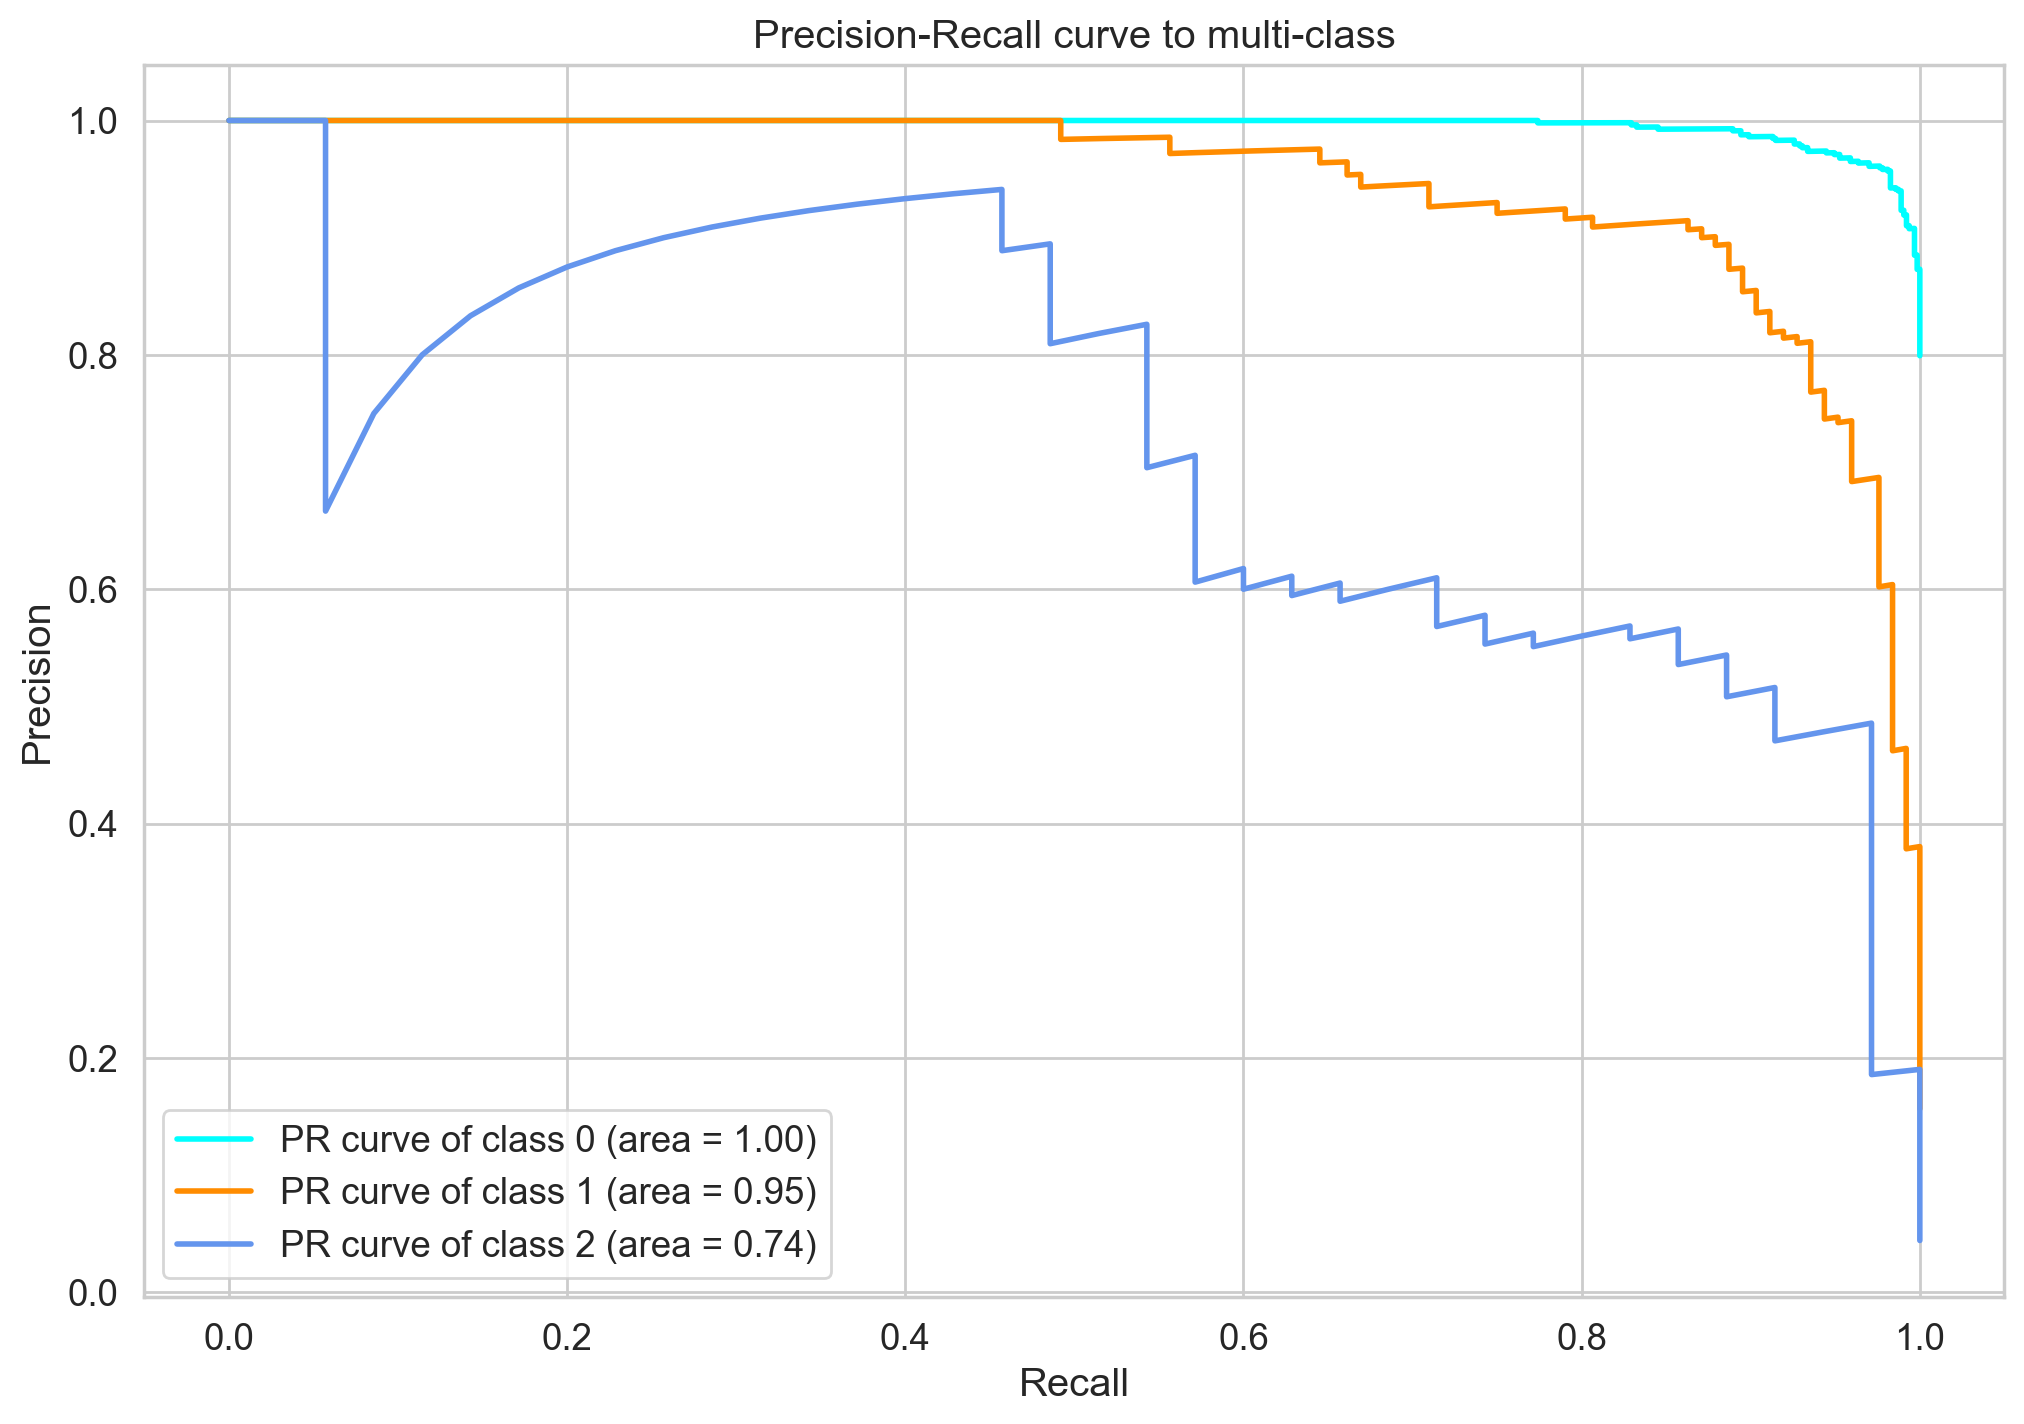

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(labels, probs):
    
    precision = {}
    recall = {}
    average_precision = {}
    test_labels_one_hot = np.eye(3)[labels]
    
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(test_labels_one_hot[:, i], probs[:, i])
        average_precision[i] = average_precision_score(test_labels_one_hot[:, i], probs[:, i])

    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2, label='PR curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve to multi-class')
    plt.legend(loc="best")
    plt.show()

plot_pr_curve(test_labels, probs)

## 混淆矩阵

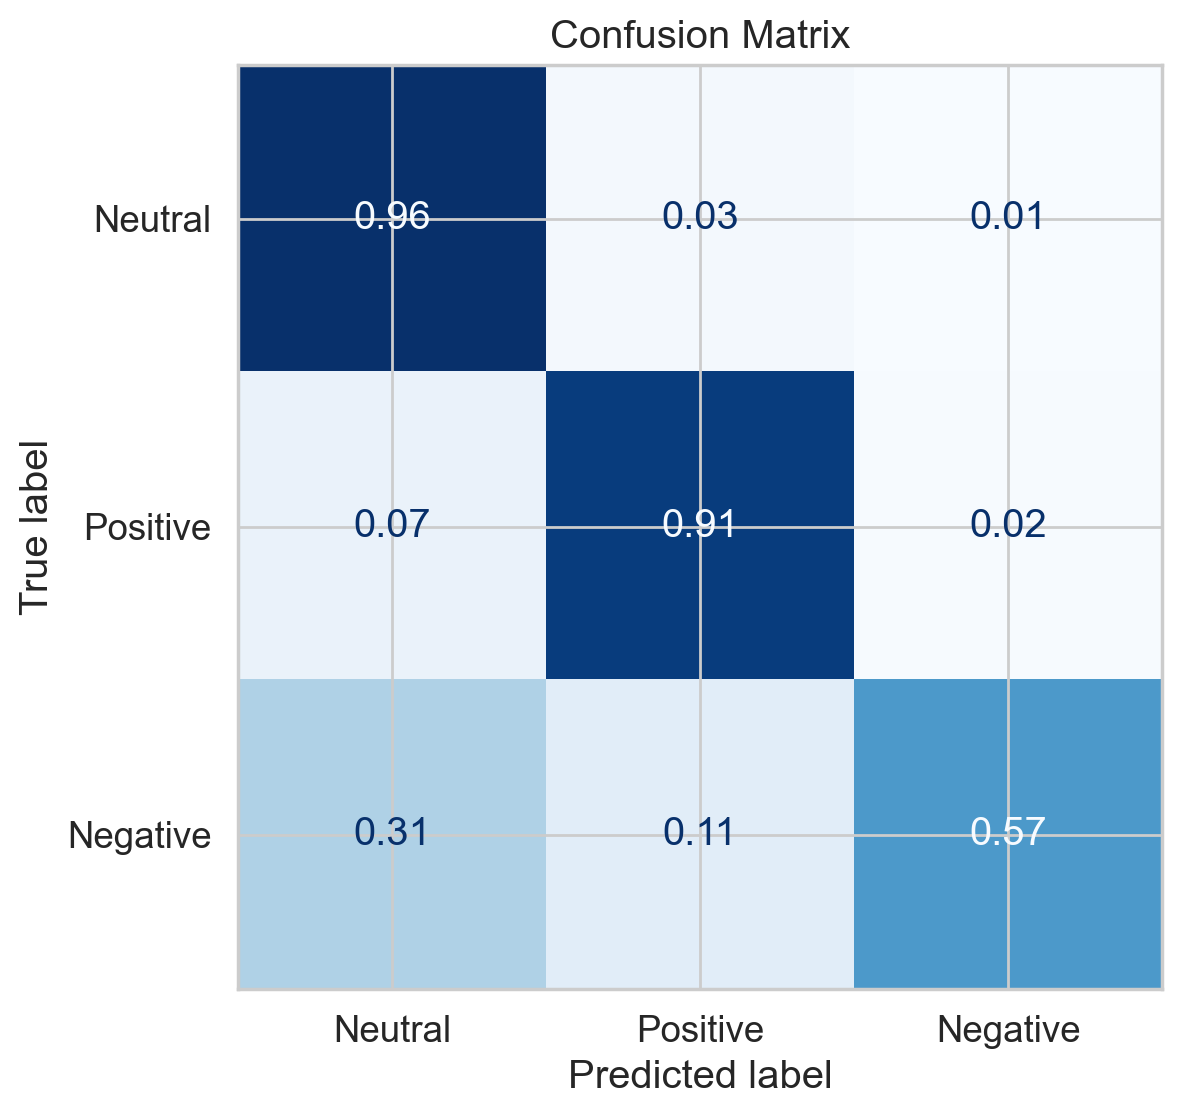

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Confusion Matrix')
    plt.show()
    
predicted_labels = np.argmax(predictions.predictions, axis=1)
plot_confusion_matrix(test_labels, predicted_labels, list(label2id.keys()))

## 误差分析

In [21]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        if loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0, reduction='none')
        elif loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0, reduction='none')
        else:
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(output.logits, batch["label"].to(device))

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

tokenized_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_data["validation"] = tokenized_data["validation"].map(forward_pass_with_label, batched=True, batch_size=16)
tokenized_data.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tokenized_data["validation"][:][cols]
df_test["label"] = df_test["label"].map(id2label)
df_test["predicted_label"] = (df_test["predicted_label"].map(id2label))
df_test.sort_values("loss", ascending=False).head(30)

Map:   0%|          | 0/791 [00:00<?, ? examples/s]

,text,label,predicted_label,loss
100,This strategy is commonly used in MT evaluatio...,Negative,Positive,3.542631
82,"Presently, many systems , , , focus on on...",Negative,Positive,3.032585
638,"As a result, the good results of with large ...",Positive,Neutral,3.032422
497,"Thus, the Penn Treebank of American English ...",Positive,Neutral,2.577766
312,"Unlike minimum error rate training , our syst...",Negative,Positive,2.362599
654,In agreement with recent results on parsing wi...,Positive,Neutral,1.949334
169,In this paper we adopt a maximum entropy model...,Neutral,Positive,1.855568
651,The dataset is available only in English and h...,Neutral,Positive,1.815108
388,Not only is this beneficial in terms of parsin...,Neutral,Positive,1.405423
392,The various extraction measures have been disc...,Neutral,Positive,1.322479


In [19]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
256,The model was trained using minimum error rate...,Neutral,Neutral,0.000010
482,We therefore ran the dependency model on a tes...,Neutral,Neutral,0.000010
331,"In the experiment, only the first 500 sentence...",Neutral,Neutral,0.000011
455,Baseline Pharaoh with phrases extracted from I...,Neutral,Neutral,0.000012
145,2 Data and annotation Yahoo!s image query API ...,Neutral,Neutral,0.000012
613,The translation quality is evaluated by BLEU m...,Neutral,Neutral,0.000012
224,We have chosen to work with a corpus with pars...,Neutral,Neutral,0.000012
577,"Given the parallel corpus, we tagged the Engli...",Neutral,Neutral,0.000012
419,"In a phrase-based statistical translation , a...",Neutral,Neutral,0.000012
569,Table 2: The set of tags used to mark explicit...,Neutral,Neutral,0.000013


In [20]:
# from torch.utils.data import DataLoader
# 
# best_model_dir = f'./citation_finetuned_models/{base_model_name}'
# trainer.save_model(best_model_dir)
# best_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir).to(device)
# 
# def load_sentiment_datasets(test_size=0.4, seed=42):
#     df = pd.read_csv(f'../data/citation_sentiment_corpus.csv')
# 
#     label_map = {'o': 0, 'p': 1, 'n': 2}
#     df['Sentiment'] = df['Sentiment'].map(label_map)
# 
#     train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Citation_Text'].tolist(), df['Sentiment'].tolist(), test_size=test_size, stratify=df['Sentiment'], random_state=seed)
#     val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=seed)
#     
#     return train_texts, train_labels, val_texts, val_labels, test_texts, test_labels
# 
# test_texts, test_labels, _, _, _, _,  = load_sentiment_datasets(test_size=0.1, seed=seed)
# test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
# predictions = trainer.predict(test_dataset)
# preds = predictions.predictions.argmax(-1)
# 
# # Compute metrics
# accuracy = accuracy_score(test_labels, preds)
# precision, recall, f1, _ = precision_recall_fscore_support(test_labels, preds, average='macro')
# 
# # Print metrics
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")